# Forecasting flight delays for domestic flights in US 

The ideia behind this project is to develop a model to predict flight delays (in minutes) at arrival for domestic flights in the US. The data used here was download from the Bureau of Transportation Statistics ([BTS](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236)). 

The dataset comprises data between January 2017 and September 2018, with more than 10 millions training examples. I plan to start with a smaller dataset, with data from June to September 2018, and then gradually increase it to see how the model behaves. 

----------------
----------------
**Features:**
* Year: 2017 to 2018.             
* Month: 1 to 12.                   
* Day_of_month: 1 to 31.            
* Day_of_week: 1 (Monday) to 7 (Sunday), 9 (Unknown).                       
* Op_carrier: Code assigned by IATA and commonly used to identify a carrier. May not be unique.         
* Op_carrier_fl_num: Flight number.             
* Origin: Origin airport.                               
* Origin_city_name: City name of the origin airport.                
* Origin_state_nm: State code of the origin airport.                  
* Dest: Destination airport.              
* Dest_city_name: City name of the destination airport.                
* Dest_state_nm: State name of the destination airport.                   
* CRS_dep_time: The schedule departure time (local time: hhmm).           
* Dep_delay_new: Difference in minutes between scheduled and actual departure time. Early departures set to 0.                 
* CRS_arr_time: The schedule arrival time (local time: hhmm).                                                    
* Arr_delay_new: Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0.                  
* Cancelled: Cancelled flight indicator, 0 (No), 1 (Yes).                                                       
* Diverted: Diverted flight indicator, 0 (No), 1 (Yes).               
* CRS_elapsed_time: The schedule elapsed time of flight, in minutes.                  
* Distance: Distance between aiportes, in miles.                      
---------------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)

from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
sep_2018 = pd.read_csv('./CSV_files/2018_09.csv')
aug_2018 = pd.read_csv('./CSV_files/2018_08.csv')
jul_2018 = pd.read_csv('./CSV_files/2018_07.csv')
jun_2018 = pd.read_csv('./CSV_files/2018_06.csv')

In [3]:
sep_2018.shape, aug_2018.shape, jul_2018.shape, jun_2018.shape

((585749, 20), (644673, 20), (645299, 20), (626193, 20))

In [4]:
flights_raw = pd.concat([jun_2018, jul_2018, aug_2018, sep_2018], ignore_index=True)

In [5]:
# the months period to which the dataset corresponds to
months_period = 4

In [6]:
flights_raw.shape

(2501914, 20)

In [7]:
flights_raw.sample(10)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
86089,2018,6,30,6,OH,5124,PHL,"Philadelphia, PA",Pennsylvania,ORF,"Norfolk, VA",Virginia,1619,8.0,1726,0.0,0,0,67,212
1793001,2018,8,25,6,NK,184,LAX,"Los Angeles, CA",California,CLE,"Cleveland, OH",Ohio,2150,4.0,520,0.0,0,0,270,2052
2257249,2018,9,3,1,OO,3314,SEA,"Seattle, WA",Washington,SLC,"Salt Lake City, UT",Utah,1745,0.0,2057,0.0,0,0,132,689
322286,2018,6,27,3,AA,1639,CLT,"Charlotte, NC",North Carolina,LGA,"New York, NY",New York,1005,0.0,1207,0.0,0,0,122,544
509023,2018,6,17,7,DL,2082,SFO,"San Francisco, CA",California,ATL,"Atlanta, GA",Georgia,1100,15.0,1849,7.0,0,0,289,2139
2041222,2018,9,8,6,WN,2691,ALB,"Albany, NY",New York,TPA,"Tampa, FL",Florida,720,0.0,1020,0.0,0,0,180,1130
2471188,2018,9,1,6,DL,999,MSP,"Minneapolis, MN",Minnesota,LGA,"New York, NY",New York,1300,0.0,1639,0.0,0,0,159,1020
882262,2018,7,13,5,DL,2693,DTW,"Detroit, MI",Michigan,DCA,"Washington, DC",Virginia,2000,0.0,2126,0.0,0,0,86,405
1941823,2018,9,22,6,MQ,3369,ORD,"Chicago, IL",Illinois,AZO,"Kalamazoo, MI",Michigan,840,0.0,1030,0.0,0,0,50,122
2056274,2018,9,20,4,YV,5885,FAT,"Fresno, CA",California,PHX,"Phoenix, AZ",Arizona,1915,117.0,2053,120.0,0,0,98,493


In [8]:
flights_raw.info(null_counts=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501914 entries, 0 to 2501913
Data columns (total 20 columns):
YEAR                 2501914 non-null int64
MONTH                2501914 non-null int64
DAY_OF_MONTH         2501914 non-null int64
DAY_OF_WEEK          2501914 non-null int64
OP_CARRIER           2501914 non-null object
OP_CARRIER_FL_NUM    2501914 non-null int64
ORIGIN               2501914 non-null object
ORIGIN_CITY_NAME     2501914 non-null object
ORIGIN_STATE_NM      2501914 non-null object
DEST                 2501914 non-null object
DEST_CITY_NAME       2501914 non-null object
DEST_STATE_NM        2501914 non-null object
CRS_DEP_TIME         2501914 non-null int64
DEP_DELAY_NEW        2459542 non-null float64
CRS_ARR_TIME         2501914 non-null int64
ARR_DELAY_NEW        2451134 non-null float64
CANCELLED            2501914 non-null int64
DIVERTED             2501914 non-null int64
CRS_ELAPSED_TIME     2501914 non-null int64
DISTANCE             2501914 non-null in

------------
-------------
It seems that only DEP_DELAY_NEW and ARR_DELAY_NEW have some missing values, corresponding to approximately 1.7 and 2.0% of the training dataset, respectively. Some of these missing values may be due to flights that were cancelled or diverted.
As we are only intereted in flights that haven't been neither cancelled nor diverted, we can drop all rows where 'CANCELLED' or 'DIVERTED' reads 1. 

After that we can also drop both CANCELLED AND DIVERTED features as they don't really give us much information.

-------------
---------------

### Filling in missing values

In [9]:
flights_raw.loc[(flights_raw.DIVERTED == 1) | (flights_raw.CANCELLED == 1)].isnull().sum()

YEAR                     0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
OP_CARRIER               0
OP_CARRIER_FL_NUM        0
ORIGIN                   0
ORIGIN_CITY_NAME         0
ORIGIN_STATE_NM          0
DEST                     0
DEST_CITY_NAME           0
DEST_STATE_NM            0
CRS_DEP_TIME             0
DEP_DELAY_NEW        40464
CRS_ARR_TIME             0
ARR_DELAY_NEW        49681
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
DISTANCE                 0
dtype: int64

In [10]:
#droping flights that were cancelled or diverted
flights_df = flights_raw.loc[(flights_raw.DIVERTED == 0) & (flights_raw.CANCELLED == 0)]

In [11]:
flights_df.isnull().sum()

YEAR                    0
MONTH                   0
DAY_OF_MONTH            0
DAY_OF_WEEK             0
OP_CARRIER              0
OP_CARRIER_FL_NUM       0
ORIGIN                  0
ORIGIN_CITY_NAME        0
ORIGIN_STATE_NM         0
DEST                    0
DEST_CITY_NAME          0
DEST_STATE_NM           0
CRS_DEP_TIME            0
DEP_DELAY_NEW        1908
CRS_ARR_TIME            0
ARR_DELAY_NEW        1099
CANCELLED               0
DIVERTED                0
CRS_ELAPSED_TIME        0
DISTANCE                0
dtype: int64

In [12]:
# null_data is a subset of flights_df with all instances that have at least one missing value 
null_data = flights_df[flights_df.isnull().any(axis=1)]
null_data.sample(15)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
1589908,2018,8,15,3,9E,3303,ATL,"Atlanta, GA",Georgia,AGS,"Augusta, GA",Georgia,1346,NaN,1442,5.0,0,0,56,143
1299169,2018,8,17,5,9E,5261,CLT,"Charlotte, NC",North Carolina,JFK,"New York, NY",New York,657,NaN,900,0.0,0,0,123,541
646185,2018,7,31,2,9E,5187,SYR,"Syracuse, NY",New York,LGA,"New York, NY",New York,948,5.0,1103,NaN,0,0,75,198
647121,2018,7,29,7,9E,5220,LGA,"New York, NY",New York,CLE,"Cleveland, OH",Ohio,1045,NaN,1245,0.0,0,0,120,419
636221,2018,7,28,6,9E,5317,LGA,"New York, NY",New York,ROC,"Rochester, NY",New York,1135,NaN,1305,17.0,0,0,90,254
573349,2018,6,15,5,9E,3396,DTW,"Detroit, MI",Michigan,SYR,"Syracuse, NY",New York,1210,0.0,1329,NaN,0,0,79,374
573294,2018,6,30,6,9E,3394,RDU,"Raleigh/Durham, NC",North Carolina,JFK,"New York, NY",New York,1345,NaN,1530,0.0,0,0,105,427
569422,2018,6,30,6,9E,3282,FAY,"Fayetteville, NC",North Carolina,ATL,"Atlanta, GA",Georgia,1530,NaN,1704,0.0,0,0,94,331
561187,2018,6,8,5,9E,5467,CVG,"Cincinnati, OH",Kentucky,BOS,"Boston, MA",Massachusetts,720,NaN,926,0.0,0,0,126,752
570317,2018,6,6,3,9E,3306,BGR,"Bangor, ME",Maine,LGA,"New York, NY",New York,755,NaN,935,0.0,0,0,100,378


In [13]:
null_data.describe(include=['O'])

,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM
count,2950,2950,2950,2950,2950,2950,2950
unique,1,105,103,35,105,103,35
top,9E,ATL,"New York, NY",New York,LGA,"New York, NY",New York
freq,2950,389,586,707,362,660,783


In [14]:
null_data.describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
count,2950.0,2950.000000,2950.000000,2950.000000,2950.000000,2950.000000,1042.000000,2950.000000,1851.000000,2950.0,2950.0,2950.000000,2950.000000
mean,2018.0,6.935932,16.239661,3.958644,4487.194576,1302.136949,2.790787,1483.093559,3.406267,0.0,0.0,109.288814,480.069831
std,0.0,0.819583,8.677672,1.964327,875.878808,448.451751,5.903514,451.039833,10.664325,0.0,0.0,35.210089,268.827406
min,2018.0,6.000000,1.000000,1.000000,3280.000000,533.000000,0.000000,629.000000,0.000000,0.0,0.0,43.000000,83.000000
25%,2018.0,6.000000,9.000000,2.000000,3443.000000,940.000000,0.000000,1122.000000,0.000000,0.0,0.0,83.000000,264.000000
50%,2018.0,7.000000,17.000000,4.000000,5063.000000,1250.000000,0.000000,1442.000000,0.000000,0.0,0.0,104.000000,419.000000
75%,2018.0,8.000000,24.000000,6.000000,5243.000000,1643.500000,3.000000,1840.000000,0.000000,0.0,0.0,130.750000,645.000000
max,2018.0,8.000000,31.000000,7.000000,5479.000000,2333.000000,46.000000,2355.000000,148.000000,0.0,0.0,243.000000,1391.000000


In [15]:
# quicly checking how many flights there were per airline, especially 9E
flights_df.OP_CARRIER.value_counts()

WN    450980
DL    334788
AA    307454
OO    265872
UA    220639
YX    104996
B6    101433
MQ     98672
AS     91346
OH     89422
9E     83634
YV     75032
EV     64119
NK     60802
F9     40586
G4     33425
HA     29033
Name: OP_CARRIER, dtype: int64

------------
------------
Just by dropping the flights that were either cancelled or diverted, the number of missing values of DEP_DELAY_NEW and ARR_DELAY_NEW decreased significantly, but we still have some missing values to deal with. All the remaning missing values are from flights operated by the airline 9E (Endeavor Air), which is something interesting. We could input these missing values with the mean or median values, but, given the size of the dataset, I guess we can drop these values without losing too much information. Furthermore, I don't see the point of filling in the missing values of the dependent variable (ARR_DELAY_NEW).

Just out of curiosity, during the months of June, July, August and September, 49681 flights were cancelled or diverted in the US.

------------
------------

In [16]:
#drop all remaining missing values
flights_df = flights_df.dropna()

In [17]:
flights_df.isnull().sum()

YEAR                 0
MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
ORIGIN_CITY_NAME     0
ORIGIN_STATE_NM      0
DEST                 0
DEST_CITY_NAME       0
DEST_STATE_NM        0
CRS_DEP_TIME         0
DEP_DELAY_NEW        0
CRS_ARR_TIME         0
ARR_DELAY_NEW        0
CANCELLED            0
DIVERTED             0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64

-------
-------
### Feature control dataset

In [18]:
# Create a pandas DataFrame to control what is going on with the features

FeatCtrl = ['0 - not inspected',                      
            '1 - inspected and ready',                   
            '2 - drop before training',                        
            '3 - created and ready',                  
            '4 - inspected and consider binning']  

flights_FeatCtrl = pd.DataFrame(np.zeros((1,len(flights_df.columns))), dtype=int, columns = flights_df.columns)
print(flights_FeatCtrl.shape)

(1, 20)


In [19]:
flights_FeatCtrl['CANCELLED'] = 2
flights_FeatCtrl['DIVERTED'] = 2

----------
----------

## Some stats

Now that there isn't any remaining missing value in the dependent variable, we can check the frequency that flights are delayed at arrival.


In [20]:
#Code for Plotly histogram graph (code was commented due to the large size of the graph)

'''arr_delay = go.Histogram(x=summer_flights['ARR_DELAY_NEW'], name='arrival', nbinsx=200)

layout = go.Layout(title='Distribution of Flight Delays', 
                   xaxis=dict(title='Delay time (min)'),
                   yaxis=dict(title='Count of flights', type='log'),
                   bargroupgap=0.2,
                   barmode='overlay')

data = [arr_delay]

hist_flight_delay = go.Figure(data=data, layout=layout)
iplot(hist_flight_delay)'''

"arr_delay = go.Histogram(x=summer_flights['ARR_DELAY_NEW'], name='arrival', nbinsx=200)\n\nlayout = go.Layout(title='Distribution of Flight Delays', \n                   xaxis=dict(title='Delay time (min)'),\n                   yaxis=dict(title='Count of flights', type='log'),\n                   bargroupgap=0.2,\n                   barmode='overlay')\n\ndata = [arr_delay]\n\nhist_flight_delay = go.Figure(data=data, layout=layout)\niplot(hist_flight_delay)"

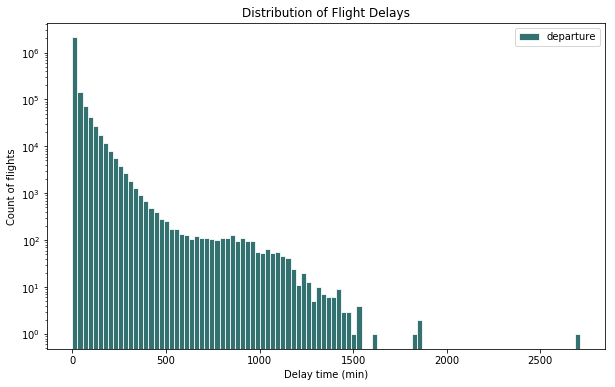

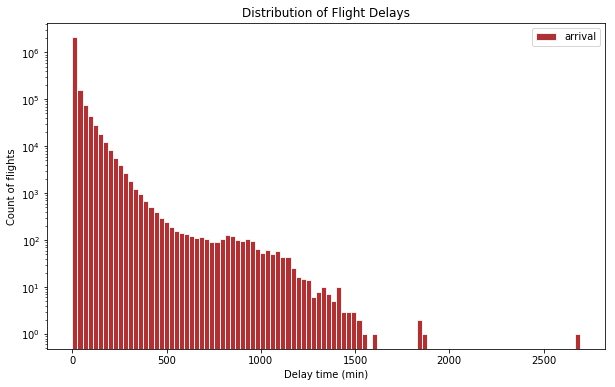

In [133]:
plt.figure(figsize=(10,6))
grid = sns.distplot(flights_df['DEP_DELAY_NEW'], kde=False, bins=100, color=sns.xkcd_rgb['dark teal'], 
                    hist_kws={'edgecolor':'white', 'log':True, 'alpha':0.8}, label='departure')
grid.set_title('Distribution of Flight Delays')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time (min)')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
grid = sns.distplot(flights_df['ARR_DELAY_NEW'], kde=False, bins=100, color=sns.xkcd_rgb['blood red'], 
                    hist_kws={'edgecolor':'white', 'log':True, 'alpha':0.8}, label='arrival')
grid.set_title('Distribution of Flight Delays')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time (min)')
plt.legend()
plt.show()

In [22]:
flights_df.describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
count,2449283.0,2.449283e+06,2.449283e+06,2.449283e+06,2.449283e+06,2.449283e+06,2.449283e+06,2.449283e+06,2.449283e+06,2449283.0,2449283.0,2.449283e+06,2.449283e+06
mean,2018.0,7.477432e+00,1.588785e+01,3.994459e+00,2.614253e+03,1.328873e+03,1.507424e+01,1.480044e+03,1.547418e+01,0.0,0.0,1.408868e+02,8.101642e+02
std,0.0,1.104612e+00,8.755905e+00,1.998427e+00,1.859048e+03,4.938811e+02,4.656568e+01,5.219093e+02,4.658760e+01,0.0,0.0,7.350631e+01,6.085029e+02
min,2018.0,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.0,1.000000e+00,3.100000e+01
25%,2018.0,6.000000e+00,8.000000e+00,2.000000e+00,1.044000e+03,9.100000e+02,0.000000e+00,1.055000e+03,0.000000e+00,0.0,0.0,8.800000e+01,3.660000e+02
50%,2018.0,7.000000e+00,1.600000e+01,4.000000e+00,2.174000e+03,1.320000e+03,0.000000e+00,1.510000e+03,0.000000e+00,0.0,0.0,1.210000e+02,6.390000e+02
75%,2018.0,8.000000e+00,2.300000e+01,6.000000e+00,4.094000e+03,1.735000e+03,8.000000e+00,1.918000e+03,1.000000e+01,0.0,0.0,1.700000e+02,1.042000e+03
max,2018.0,9.000000e+00,3.100000e+01,7.000000e+00,7.439000e+03,2.359000e+03,2.710000e+03,2.359000e+03,2.692000e+03,0.0,0.0,6.580000e+02,4.983000e+03


In [23]:
flights_df.describe(include=['O'])

,OP_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM
count,2449283,2449283,2449283,2449283,2449283,2449283,2449283
unique,17,351,345,52,351,345,52
top,WN,ATL,"Chicago, IL",California,ATL,"Chicago, IL",California
freq,450980,133684,144963,271959,133641,144632,272427


-----------
-----------
Just by a quick look at the statistics, it seems there are some "weird" values in the dataset, such CRS_ELAPSED_TIME of 1 min and ARR_DELAY_NEW of 2692 min (~ 45h).

*The maximum distance observed in the dataset is 4983 miles (almost 8020 km), which at a first glance seems to be an outlier, but after a further check I discovered it is quite right: it's the distance between Hoolulu (HNL) and New York (JFK) airports.

-------------
-------------

In [24]:
#The shortest commercial flight in US lasts 16 min
flights_df[flights_df.CRS_ELAPSED_TIME <= 15]

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE
109223,2018,6,2,6,OO,5132,SLN,"Salina, KS",Kansas,HYS,"Hays, KS",Kansas,1710,0.0,1715,16.0,0,0,5,88
787441,2018,7,10,2,YV,5903,MTJ,"Montrose/Delta, CO",Colorado,DFW,"Dallas/Fort Worth, TX",Texas,1227,13.0,1328,194.0,0,0,1,722
1143291,2018,7,4,3,YX,4493,MSP,"Minneapolis, MN",Minnesota,LGA,"New York, NY",New York,709,43.0,810,216.0,0,0,1,1020
1412070,2018,8,19,7,OH,5123,CLT,"Charlotte, NC",North Carolina,PGV,"Greenville, NC",North Carolina,2225,24.0,2226,89.0,0,0,1,203


In [25]:
# It seems that what we have here are wrong values for CRS_ELAPSED_TIME. So I'm dropping them.
flights_df = flights_df[flights_df.CRS_ELAPSED_TIME >= 15]

---------
---------
## Spliting training-test set

Before further inspecting the data closely, we need to split it into training and test set.
I believe that airport capacity (flights/month) may be an important attribute to predict flight delays time. To ensure that the test set is similar to the training set regarding the airport capacity, we can split the dataset using the Scikit-Learn's *StratifiedShuffleSplit* class.

The dataset is expressed as a fraction of month, day and airline, so in order to make training and test set more homogeneous, we also need to suffle the data (StratifiedShuffleSplit will do it automatically). It will also enhance the robustness of the cross validation as all cross-validation folds will be similar.

Let us divide the airports in bins based on their capacity:

In [26]:
airports_flights_per_month = ((flights_df['ORIGIN'].value_counts() + flights_df['DEST'].value_counts()) / 
                          months_period).sort_values(ascending=False)
airports_flights_per_month

ATL    66831.25
ORD    57280.00
DFW    47644.50
DEN    41960.25
CLT    38768.75
LAX    38155.50
SFO    30409.50
IAH    29349.25
MSP    28552.75
PHX    28055.00
LGA    27816.00
LAS    27259.25
DTW    26851.25
SEA    26007.00
BOS    25399.50
EWR    23560.50
MCO    21994.00
JFK    21936.25
DCA    21289.25
PHL    19870.50
SLC    19473.75
BWI    17907.75
SAN    15728.50
FLL    15265.50
MDW    15118.75
MIA    14106.25
BNA    12637.25
IAD    12052.25
DAL    11734.25
PDX    11582.00
TPA    11445.00
STL    11192.50
AUS    11059.75
RDU    10157.25
MCI     9663.75
HOU     9619.50
SJC     9411.00
OAK     9145.75
MSY     8997.50
CVG     8580.50
HNL     8543.00
PIT     8241.25
SMF     8135.50
IND     8082.75
CLE     8081.25
CMH     7689.25
SNA     7148.25
SAT     6769.50
JAX     5398.00
MKE     5330.25
BDL     4601.00
BUF     4446.00
OGG     4361.75
BUR     4340.00
OMA     4337.50
SJU     4325.75
ABQ     4316.75
CHS     4150.25
OKC     4077.50
ORF     3997.00
ANC     3981.50
SDF     3970.75
MEM     

In [27]:
airports_flights_per_month.describe()

count      351.000000
mean      3489.001425
std       8294.514883
min         11.500000
25%        163.125000
50%        554.250000
75%       2276.500000
max      66831.250000
dtype: float64

In [122]:
#size of airport bins
airports_capacity = pd.cut(airports_flights_per_month, [0, 250, 500, 1000, 5000, 10000, 20000, 80000]
                          ).value_counts().sort_index()
airports_capacity

(0, 250]          127
(250, 500]         41
(500, 1000]        55
(1000, 5000]       78
(5000, 10000]      16
(10000, 20000]     15
(20000, 80000]     19
dtype: int64

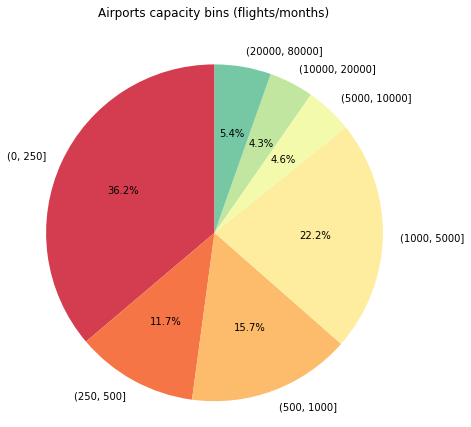

In [72]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0.1, 1, 9)]

grid = airports_capacity.plot.pie(y=airports_capacity.index,
                               startangle=90,
                               autopct='%1.1f%%', 
                               colors=colors)
grid.axis('equal')
grid.yaxis.set_label_text('')
grid.set_title('Airports capacity bins (flights/months)', y=1.08)
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.tight_layout()
plt.show()

------------
------------
As one can see, there are 351 aiports with capacity ranging from 5 flights to more than 30000 flights per month. Approximately 75% of the US airports operate less then 1200 flights/month. The airports were divided into 9 new categories based on their capacity:               
{0 : '(0, 250]',         
 1 : '(250, 500]',              
 2 : '(500, 1000],                   
 3 : '(1000, 5000]',          
 4 : '(5000, 10000]',                
 5 : '(10000, 20000]',          
 6 : '(20000, 80000]}                  


------------
------------

In [105]:
# binning airports (ORIGIN and DEST) by their flight capacity

def airports_capacity_bins(df):
    airports_flights_per_month = (flights_df['ORIGIN'].value_counts() + flights_df['DEST'].value_counts()) / months_period
    airport_cat = pd.cut(airports_flights_per_month, [0, 250, 500, 1000, 5000, 10000, 20000, 80000], labels = [0,1,2,3,4,5,6])
    df['AIRP_ORIGIN'] = df['ORIGIN'].map(airport_cat).cat.codes
    df['AIRP_DEST'] = df["DEST"].map(airport_cat).cat.codes
    
    return df.sample(5)

flights_FeatCtrl['AIRP_ORIGIN'] = 3
flights_FeatCtrl['AIRP_DEST'] = 3

In [113]:
airports_capacity_bins(flights_df)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,CRS_DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_DELAY_NEW,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,AIRP_ORIGIN,AIRP_DEST
2130073,2018,9,25,2,HA,394,LIH,"Lihue, HI",Hawaii,HNL,"Honolulu, HI",Hawaii,1356,0.0,1432,0.0,0,0,36,102,3,4
2326098,2018,9,4,2,AA,1578,DFW,"Dallas/Fort Worth, TX",Texas,MSP,"Minneapolis, MN",Minnesota,1835,0.0,2059,0.0,0,0,144,852,6,6
21334,2018,6,9,6,EV,4138,IND,"Indianapolis, IN",Indiana,EWR,"Newark, NJ",New Jersey,1140,0.0,1348,0.0,0,0,128,645,4,6
750720,2018,7,27,5,WN,2482,SEA,"Seattle, WA",Washington,SJC,"San Jose, CA",California,515,0.0,725,0.0,0,0,130,696,6,4
281182,2018,6,7,4,AA,21,DEN,"Denver, CO",Colorado,DFW,"Dallas/Fort Worth, TX",Texas,1247,0.0,1545,0.0,0,0,118,641,6,6


In [114]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2449279 entries, 0 to 2449278
Data columns (total 22 columns):
YEAR                 int64
MONTH                int64
DAY_OF_MONTH         int64
DAY_OF_WEEK          int64
OP_CARRIER           object
OP_CARRIER_FL_NUM    int64
ORIGIN               object
ORIGIN_CITY_NAME     object
ORIGIN_STATE_NM      object
DEST                 object
DEST_CITY_NAME       object
DEST_STATE_NM        object
CRS_DEP_TIME         int64
DEP_DELAY_NEW        float64
CRS_ARR_TIME         int64
ARR_DELAY_NEW        float64
CANCELLED            int64
DIVERTED             int64
CRS_ELAPSED_TIME     int64
DISTANCE             int64
AIRP_ORIGIN          int8
AIRP_DEST            int8
dtypes: float64(2), int64(11), int8(2), object(7)
memory usage: 378.4+ MB


In [88]:
#creating a dictionary for future reference of airports bins/categories
airport_cat_dict = {0 : '(0, 250]', 1 : '(250, 500]', 2 : '(500, 1000]', 3 : '(1000, 5000]', 4 : '(500, 10000]',
                    5 : '(10000, 20000]', 6 : '(20000, 80000]'}

In [115]:
# Spliting data into training and test sets
def train_test_split(df):
    df.reset_index(drop=True, inplace=True)
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=87)
    for train_index, test_index in split.split(df, df['AIRP_DEST']):
        train = df.loc[train_index]
        test = df.loc[test_index]
    print('Training shape:', train.shape)
    print('Test set shape:', test.shape)
    return (train, test)

In [116]:
flights_train, flights_test = train_test_split(flights_df)

Training shape: (1836959, 22)
Test set shape: (612320, 22)


-------------------
-------------------
## Exploratory data analysis

Ok, now that we had our dataset split, we can explore the data a little bit more in depth. To make manipulation easy and fast, let's sample a smaller exploratory set first.

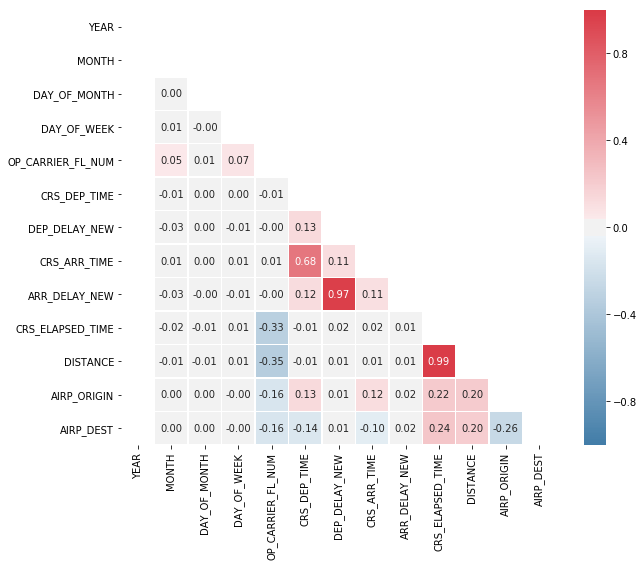

In [119]:
columns_to_keep = flights_FeatCtrl.loc[:, (flights_FeatCtrl != 2).any(axis=0)].columns

corr = flights_train[columns_to_keep].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
grid = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cmap=cmap, vmin=-1, center=0, linewidths=.5)
plt.show()

---------
---------
#### Outliers

From the histogram up above it seems that we have some outliers on delays time.

In [136]:
# Looking for flights that arrived more than 20h (1200 min) later.
print('Delays by over 20h (departure):', flights_train[flights_train.DEP_DELAY_NEW >= 1200].shape[0])
print('Delays by over 20h (arrival):', flights_train[flights_train.ARR_DELAY_NEW >= 1200].shape[0])
print()

# Looking for flights that arrived more than 10h (600 min) later.
print('Delays by over 10h (departure):', flights_train[flights_train.DEP_DELAY_NEW >= 600].shape[0])
print('Delays by over 10h:', flights_train[flights_train.ARR_DELAY_NEW >= 600].shape[0])

Delays by over 20h (departure): 82
Delays by over 20h (arrival): 79

Delays by over 10h (departure): 1521
Delays by over 10h: 1517


-------------
-------------
Given the small amount of flights that were delayed by over 20h, we can see that they are not recurrent and may be due to "extraordinary circumstances". Actually, I would even say that delays over 10 hours are often beyond the airlines’ control and are hard to predict. They are, therefore, outliers. 
For the sake of comparison, let's create 2 datasets and later check their model performance:
(I) with flights delayed up to 20 hours, and
(II) with flights delayed up to 10 hours.


--------------
--------------

In [140]:
# dropping flights that were delayed by over 20 hours
flights_train_20h = flights_train[(flights_train.ARR_DELAY_NEW <= 1200) & (flights_train.DEP_DELAY_NEW <= 1200)]

# dropping flights that were delayed by over 10 hours
flights_train_10h = flights_train[(flights_train.ARR_DELAY_NEW <= 600) & (flights_train.DEP_DELAY_NEW <= 600)]

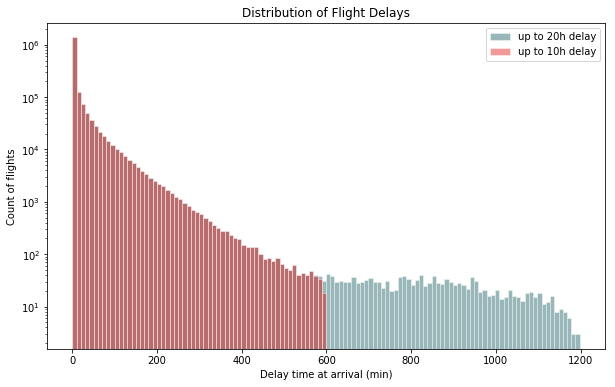

In [141]:
plt.figure(figsize=(10,6))
grid = sns.distplot(flights_train_20h['ARR_DELAY_NEW'], kde=False, bins=120, color=sns.xkcd_rgb['dark teal'], 
                    hist_kws={'edgecolor':'white', 'log':True}, label='up to 20h delay')
grid = sns.distplot(flights_train_10h['ARR_DELAY_NEW'], kde=False, bins=60, color=sns.xkcd_rgb['red'], 
                    hist_kws={'edgecolor':'white', 'log':True}, label='up to 10h delay')
grid.set_title('Distribution of Flight Delays')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time at arrival (min)')
plt.legend()
plt.show()

----------------
----------------
The training set has over 1.8 millions instances. To make the data exploration easier and faster, let us sample an explaratory set of 200k training examples from the flights_train_10h dataset.

----------------
----------------

In [143]:
# sampling an exploratory set of 200k training examples
train_explor_10h = flights_train_10h.sample(200000, random_state=87)

In [32]:
# Code for Plotly histogram graph

'''#checking if proportions were maintained
arr_delay = go.Histogram(x=flights_train_10h['ARR_DELAY_NEW'], name='arrival', nbinsx=200)
arr_delay_exp = go.Histogram(x=train_explor_10h['ARR_DELAY_NEW'], name='arrival', nbinsx=200)

layout = go.Layout(title='Distribution of Flight Delays - Original vs. Exploratory training set', 
                   xaxis=dict(title='Delay time (min)'),
                   yaxis=dict(title='Count of flights', type='log'),
                   bargroupgap=0.2,
                   barmode='overlay')

data = [arr_delay, arr_delay_exp]

hist_flight_delay = go.Figure(data=data, layout=layout)
iplot(hist_flight_delay)'''

"#checking if proportions were maintained\narr_delay = go.Histogram(x=flights_train['ARR_DELAY_NEW'], name='arrival', nbinsx=200)\narr_delay_exp = go.Histogram(x=train_explor['ARR_DELAY_NEW'], name='arrival', nbinsx=200)\n\nlayout = go.Layout(title='Distribution of Flight Delays - Original vs. Exploratory training set', \n                   xaxis=dict(title='Delay time (min)'),\n                   yaxis=dict(title='Count of flights', type='log'),\n                   bargroupgap=0.2,\n                   barmode='overlay')\n\ndata = [arr_delay, arr_delay_exp]\n\nhist_flight_delay = go.Figure(data=data, layout=layout)\niplot(hist_flight_delay)"

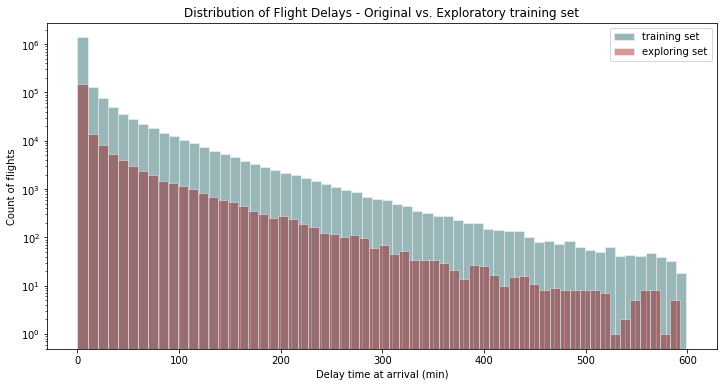

In [144]:
#checking if proportions were maintained
plt.figure(figsize=(12,6))
grid = sns.distplot(flights_train_10h['ARR_DELAY_NEW'], kde=False, bins=60, label='training set', color=sns.xkcd_rgb['dark teal'], hist_kws={'edgecolor':'white', 'log':True})
grid = sns.distplot(train_explor_10h['ARR_DELAY_NEW'], kde=False, bins=60, label='exploring set', color=sns.xkcd_rgb['blood red'], hist_kws={'edgecolor':'white', 'log':True})
grid.set_title('Distribution of Flight Delays - Original vs. Exploratory training set')
grid.set_ylabel('Count of flights')
grid.set_xlabel('Delay time at arrival (min)')
plt.legend()
plt.show()

In [148]:
original = flights_train_10h.AIRP_DEST.value_counts() / len(flights_train_10h) * 100
exploratory = train_explor_10h.AIRP_DEST.value_counts() / len(train_explor_10h) * 100
df_dtypes = pd.concat([original, exploratory], axis=1, keys=['training', 'exploratory'], join='outer', sort=True)
df_dtypes

,training,exploratory
0,1.375762,1.3790
1,1.261510,1.2645
2,3.294616,3.2485
3,15.098351,15.1345
4,10.537049,10.5075
5,17.106666,17.1805
6,51.326046,51.2855


-------
-------
It seems that the exploratory set is similar to the training set.

--------
--------

In [35]:
# Code for Plotly scatterplot graph
'''
dep_arr_delay = go.Scattergl(x=train_explor['DEP_DELAY_NEW'], y=train_explor['ARR_DELAY_NEW'], mode = 'markers', 
                             marker = dict(line = dict(width = 1)))

layout = go.Layout(title='Flight Delays at Departure vs. Arrival', 
                   xaxis=dict(title='Delay time at departure (min)'),
                   yaxis=dict(title='Delay time at arrival (min)',))
data = [dep_arr_delay]
hist_flight_delay = go.Figure(data=data, layout=layout)
iplot(hist_flight_delay)
'''

"\ndep_arr_delay = go.Scattergl(x=train_explor['DEP_DELAY_NEW'], y=train_explor['ARR_DELAY_NEW'], mode = 'markers', \n                             marker = dict(line = dict(width = 1)))\n\nlayout = go.Layout(title='Flight Delays at Departure vs. Arrival', \n                   xaxis=dict(title='Delay time at departure (min)'),\n                   yaxis=dict(title='Delay time at arrival (min)',))\ndata = [dep_arr_delay]\nhist_flight_delay = go.Figure(data=data, layout=layout)\niplot(hist_flight_delay)\n"

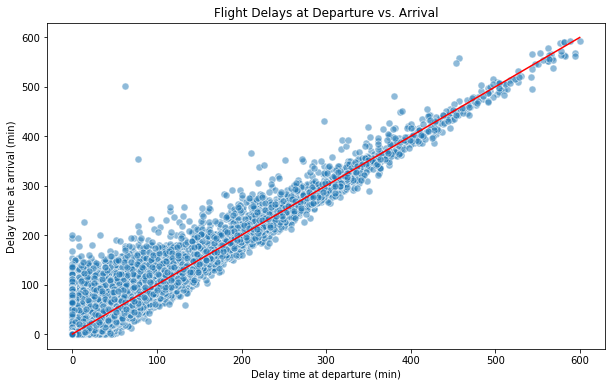

In [149]:
grid = train_explor_10h.plot(kind='scatter', x="DEP_DELAY_NEW", y="ARR_DELAY_NEW", edgecolor='w', 
                             alpha=0.5, s=50, figsize=(10,6))
grid.set_title('Flight Delays at Departure vs. Arrival')
grid.set_ylabel('Delay time at arrival (min)')
grid.set_xlabel('Delay time at departure (min)')
plt.plot([0, 600], [0, 600], c = "red")
plt.show()

In [151]:
# flights on-time -- both on departure and arrival (delay dep = 0 and delay arr = 0)
ontime_arr_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW == 0) & (train_explor_10h.ARR_DELAY_NEW == 0)]

#flights that arrived on-time but departed late -- it did "make up time" in the air (delay dep > 0 and delay arr = 0)
ontime_arr_delay_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW > 0) & (train_explor_10h.ARR_DELAY_NEW == 0)]

#flights that arrived late but departed on-time -- it was longer than expected (delay dep = 0 and delay arr > 0)
delay_arr_ontime_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW == 0) & (train_explor_10h.ARR_DELAY_NEW > 0)]

#flights delayed -- both on departure and arrival (delay dep > 0 and delay arr > 0)
delay_arr_dep = train_explor_10h[(train_explor_10h.DEP_DELAY_NEW > 0) & (train_explor_10h.ARR_DELAY_NEW > 0)]

In [152]:
delay_arr_dep['DIFF_DEP_ARR_DELAY'] = delay_arr_dep.ARR_DELAY_NEW - delay_arr_dep.DEP_DELAY_NEW

#Flights that arrived later than expected (delay arr > delay dep)
delay_arr_greater_dep = delay_arr_dep[delay_arr_dep.DIFF_DEP_ARR_DELAY > 0]

#Flights that did "make up some time" in the air (delay arr < delay dep)
delay_arr_shorter_dep = delay_arr_dep[delay_arr_dep.DIFF_DEP_ARR_DELAY < 0]

#Flights that were as delayed at arrival as at departure (delay arr = delay dep)
delay_arr_equal_dep = delay_arr_dep[delay_arr_dep.DIFF_DEP_ARR_DELAY == 0]

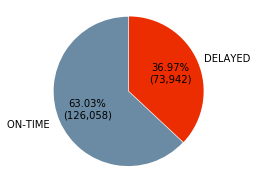

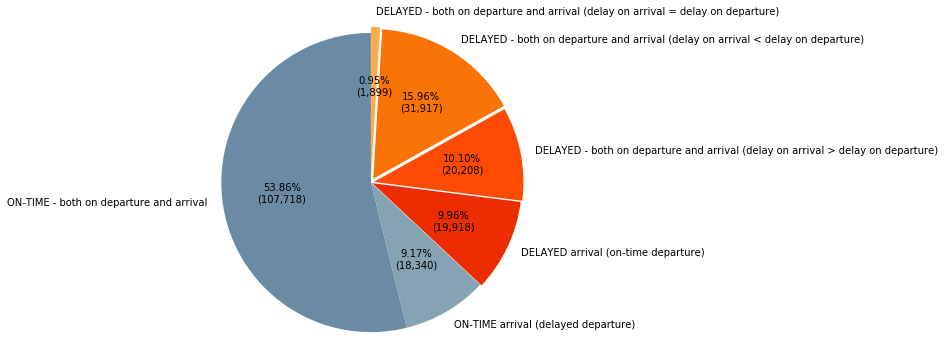

In [154]:
labels = ['ON-TIME ', 'DELAYED']
sizes = [len(ontime_arr_dep) + len(ontime_arr_delay_dep), len(delay_arr_ontime_dep) + len(delay_arr_dep)]
colors = ['#6b8ba4','#ec2d01'] 
explodeTuple = (0.0, 0.01)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p:'{:.2f}%\n({:,.0f})'.format(p,p*sum(sizes)/100), colors=colors, 
        explode=explodeTuple, startangle=90)
ax1.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(3,3)
plt.show()

labels = ['ON-TIME - both on departure and arrival', 'ON-TIME arrival (delayed departure)', 'DELAYED arrival (on-time departure)', 
          'DELAYED - both on departure and arrival (delay on arrival > delay on departure)',
          'DELAYED - both on departure and arrival (delay on arrival < delay on departure)', 
          'DELAYED - both on departure and arrival (delay on arrival = delay on departure)']
sizes = [len(ontime_arr_dep), len(ontime_arr_delay_dep), len(delay_arr_ontime_dep), len(delay_arr_greater_dep),
        len(delay_arr_shorter_dep), len(delay_arr_equal_dep)]
colors = ['#6b8ba4','#85a3b2','#ec2d01','#fe4b03', '#f97306','#fdaa48'] 
explodeTuple = (0.0, 0.0, 0.01,0.02,0.03,0.04)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p:'{:.2f}%\n({:,.0f})'.format(p,p*sum(sizes)/100), colors=colors, 
        explode=explodeTuple, startangle=90)
ax1.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()



-----------
-----------
Almost 63% of flights arrived on time, some of which (9.17%) manage to "make up time" and arrived on-time even with a delayed departure. From the 37% of flights that arrived late, almost 20% arrived later than expected due to a longer travel trip (longer than expected elapsed time) and 16% arrived late despite "making up some time" in the air (or in the ground with faster taxing, don't know).

One interesting thing to note is that the scatter plot up above is misleading: it seems that most of the delayed flights arrived even later than they departed. It is, actually, the opposite.

-------------
-------------

In [210]:
# Percentage of delayed flights per aiport category
train_explor_10h.groupby('AIRP_ORIGIN').apply(lambda x: 
                                              pd.Series({'Delayed flights': '{:.1f} %'.format(
                                                         len(x[x.ARR_DELAY_NEW != 0]) / len(x) * 100)}))

,Delayed flights
AIRP_ORIGIN,
0,30.5 %
1,30.2 %
2,31.8 %
3,32.5 %
4,34.4 %
5,39.2 %
6,38.8 %


In [222]:
# Percentage of delayed flights per aiport category
delay_per_airline = train_explor_10h.groupby('OP_CARRIER').apply(lambda x: len(x[x.ARR_DELAY_NEW != 0]) / len(x) * 100)
delay_per_airline.sort_values(inplace=True)

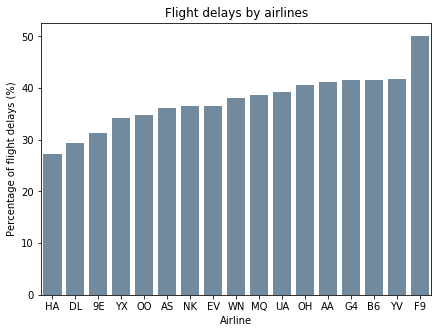

In [233]:
plt.figure(figsize=(7,5))
grid = sns.barplot(x=delay_per_airline.index, y=delay_per_airline, color=sns.xkcd_rgb['grey blue'])
grid.set_title('Flight delays by airlines')
grid.set_ylabel('Percentage of flight delays (%)')
grid.set_xlabel('Airline')
plt.show()